<font color = 'red' ><h1 style = 'text-align: center; font-family: cambria'>NOTEBOOK D'ANALYSE DE SENTIMENT AVEC UTILISATION DES LSTM</h1></font>
        <h3 style = 'text-decoration : underline; color: blue'>Objectifs : </h3>
        <li>Importer le datasets et les modules de traitement du langage naturel</li>
        <li>Pretraiter des données</li>
        <li>Encodage et vectorisation des données</li>
        <li>Creation du model</li>
        <li>Entrainer le model</li>
        <li>Prediction et analyse du resultat</li>


<h1 style = 'color : blue; font-family: cambria; text-align: center'>I- Importation des modules</h1>

<h3 style = 'color : orange; font-family: cambria'>I.1- Importation des bibliotheques</h3>

In [31]:
import os ,sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import re
import random
import string
import math
import itertools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer

# Modules pour la construction du modèle
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,Dense,Activation,LSTM,Embedding,Conv1D,Bidirectional,SpatialDropout1D,Dropout
from keras import Sequential
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.callbacks import Callback , ModelCheckpoint , CSVLogger , ReduceLROnPlateau , LearningRateScheduler , EarlyStopping
from keras.optimizers import Adam , RMSprop
from keras.preprocessing.text import Tokenizer


from sklearn.metrics import confusion_matrix , classification_report

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer , WordNetLemmatizer
from nltk.tokenize import word_tokenize , RegexpTokenizer

# Parametrages
path = 'data/training.1600000.processed.noemoticon.csv'
np.random.seed(31415)
tf.random.set_seed(2)
%matplotlib inline
plt.style.use('ggplot')

<h3 style = 'color : orange; font-family: cambria'>I.2- Importation du datasets</h3>

In [2]:
# Utilisation de la bibliotheque pandas
df = pd.read_csv(path  ,encoding = 'ISO-8859-1' , header = None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
print("Datasets de {0} lignes et {1} colonnes".format(df.shape[0] , df.shape[1]))

Datasets de 1600000 lignes et 6 colonnes


In [4]:
# Informations sur le dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
# Renommons le datasets grace a la description du datasets
df.columns = ['label' , 'time' , 'date' , 'query' , 'user_id' , 'text']

In [6]:
# Contenu de la colonne 'sentiment'
df['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

In [7]:
# recherche des valeyrs de Null
np.sum(df.isnull().any(axis = 1))

0

<h1 style = 'color : blue; font-family: cambria; text-align: center'>II- Pretraitement des donnees</h1>


<div style = 'background-color: #f05c07a9;border-radius:30px; border: 2px solid black'><br/><h3 style = 'text-align : center; font-family: cambria;font-size: 35px'>Data preparation</h3>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Reduction du dataset pour faciliter l'entrainement</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Selection des colonnes utiles</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Visualisation des differents labels</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Text processing</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>conversion du texte pour l'utilisation</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Nettoyage du texte</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Tokenisation du texte</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Normalisation du texte</li>
    <li style = 'color : grey;text-align: center; font-size: 18px'>Extraction et classification des donnees</li><br/><br/>
</div>

In [8]:
df = df.groupby('label').apply(lambda x: x.sample(n=50000)).reset_index(drop = True)

df.label.value_counts()

0    50000
4    50000
Name: label, dtype: int64

In [9]:
labels_to_sentiment = {0:"Negative", 4:"Positive"}
df.label = df.label.apply(lambda x: labels_to_sentiment[x])
df.tail()

,label,time,date,query,user_id,text
99995,Positive,2057133488,Sat Jun 06 12:26:05 PDT 2009,NO_QUERY,taylormonet23,@TheRealLilZa &quot;oh sayy can you seeeee&quo...
99996,Positive,1881538206,Fri May 22 04:56:02 PDT 2009,NO_QUERY,KatMcGraw,"If it weren't for my kids, I'd ... nevermind."
99997,Positive,1468421194,Tue Apr 07 01:33:57 PDT 2009,NO_QUERY,Lydisquidie,@Maggotron haha! we think it might have been a...
99998,Positive,1962518643,Fri May 29 11:10:10 PDT 2009,NO_QUERY,MelissaHourigan,@hezness come to Hooked on Colfax and have som...
99999,Positive,2000186591,Mon Jun 01 21:35:06 PDT 2009,NO_QUERY,KanJedi,Cleared all the bills for the month. Awesome! ...


Text(0.5, 1.0, 'Sentiment Target Distribution')

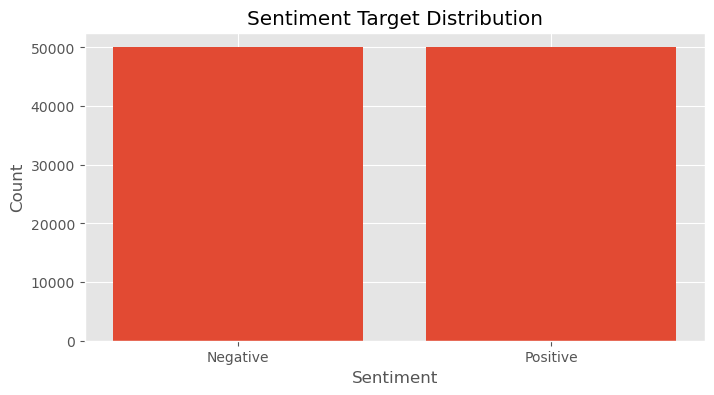

In [10]:
### Visualisation des differents labels.
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Target Distribution")

In [11]:
# exploration des nouvelle donnees
index = np.random.randint(0,1000,(10))
df.iloc[index].text

842    The Veronicas were great! But its raining now ...
717    just got home after 2 classes. had a great tim...
996         @Anna_Montanna Yeah but it isn't activated. 
690    Cub run with sammers before she leaves for ric...
565      @Dunncity  It wasn't suppose to be that easy!!!
515    I better have something in the post....been 6 ...
687    finally get to use internet after 5 days. inte...
810      Blah moving sucks. Why do I have so much stuff 
47                             Ugh I'm not tired at all 
506    @Clumsyflic the kid that got a second chance s...
Name: text, dtype: object

<h3 style = 'color : orange; font-family: cambria'>II.1- Nettoyage des donnees</h3>

In [12]:
# Transformer le texte en minuscule
df['text_trans'] = df['text'].str.lower()
df['text_trans'].tail()

99995    @thereallilza &quot;oh sayy can you seeeee&quo...
99996       if it weren't for my kids, i'd ... nevermind. 
99997    @maggotron haha! we think it might have been a...
99998    @hezness come to hooked on colfax and have som...
99999    cleared all the bills for the month. awesome! ...
Name: text_trans, dtype: object

In [13]:
# Nettoyage des donnees avec la methode stopwords de nltk
stopwords_list = stopwords.words('english')
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [14]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text_trans'] = df['text_trans'].apply(lambda text: cleaning_stopwords(text))
df['text_trans'].head()

0                @carol_carter1 think believe one time
1    @nursebc1974 know!!! boys r wide awake, n i'm ...
2    @maddieeann either mean send he's playing hard...
3    @mswindows really wish microsoft would stop pu...
4    @tommcfly still think brazilian's fans better....
Name: text_trans, dtype: object

In [15]:
# Nettoyage des ponctuations
ponctuations = string.punctuation
ponctuations_list = ponctuations

def cleaning_punctuations(text):
    translator = str.maketrans('', '', ponctuations_list)
    return text.translate(translator)

df['text_trans']= df['text_trans'].apply(lambda x: cleaning_punctuations(x))
df['text_trans'].tail()

99995    thereallilza quotoh sayy seeeeequot aha make h...
99996                                   kids id  nevermind
99997    maggotron haha think might little old lady liv...
99998                           hezness come hooked colfax
99999       cleared bills month awesome put rest aside fun
Name: text_trans, dtype: object

In [16]:
# Nettoyage des caracteres repetitifs
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

df['text_trans'] = df['text_trans'].apply(lambda x: cleaning_repeating_char(x))
df['text_trans'].tail()

99995    therealilza quotoh say sequot aha make home sa...
99996                                    kids id nevermind
99997    magotron haha think might litle old lady lives...
99998                             heznes come hoked colfax
99999        cleared bils month awesome put rest aside fun
Name: text_trans, dtype: object

In [17]:
# Nettayage des emails
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

df['text_trans']= df['text_trans'].apply(lambda x: cleaning_email(x))
df['text_trans'].tail()

99995    therealilza quotoh say sequot aha make home sa...
99996                                    kids id nevermind
99997    magotron haha think might litle old lady lives...
99998                             heznes come hoked colfax
99999        cleared bils month awesome put rest aside fun
Name: text_trans, dtype: object

In [18]:
# Nettoyage des URL
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)
df['text_trans'] = df['text_trans'].apply(lambda x: cleaning_URLs(x))
df['text_trans'].tail()

99995    therealilza quotoh say sequot aha make home sa...
99996                                    kids id nevermind
99997    magotron haha think might litle old lady lives...
99998                             heznes come hoked colfax
99999        cleared bils month awesome put rest aside fun
Name: text_trans, dtype: object

In [19]:
# Nettoyage des nombres
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

df['text_trans'] = df['text_trans'].apply(lambda x: cleaning_numbers(x))
df['text_trans'].tail()

99995    therealilza quotoh say sequot aha make home sa...
99996                                    kids id nevermind
99997    magotron haha think might litle old lady lives...
99998                             heznes come hoked colfax
99999        cleared bils month awesome put rest aside fun
Name: text_trans, dtype: object

<h1 style = 'color : blue; font-family: cambria; text-align: center'>III- Tokenisation des donnees</h1>

In [20]:
# Tokenisation du text
tokenizer = RegexpTokenizer(r'\w+')
df['text_trans'] = df['text_trans'].apply(tokenizer.tokenize)
df['text_trans'].head()

0             [carolcarter, think, believe, one, time]
1    [nursebc, know, boys, r, wide, awake, n, im, f...
2    [madiean, either, mean, send, hes, playing, ha...
3    [mswindows, realy, wish, microsoft, would, sto...
4    [tomcfly, stil, think, brazilians, fans, beter...
Name: text_trans, dtype: object

In [21]:
# Stemming

st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

df['text_trans']= df['text_trans'].apply(lambda x: stemming_on_text(x))
df['text_trans'].head()

0             [carolcarter, think, believe, one, time]
1    [nursebc, know, boys, r, wide, awake, n, im, f...
2    [madiean, either, mean, send, hes, playing, ha...
3    [mswindows, realy, wish, microsoft, would, sto...
4    [tomcfly, stil, think, brazilians, fans, beter...
Name: text_trans, dtype: object

In [22]:
#texte initial vs texte final
data = df.iloc[:1000].copy()
data[["text", "text_trans"]]

,text,text_trans
0,@carol_carter1 I don't think so I believe it ...,"[carolcarter, think, believe, one, time]"
1,"@nursebc1974 I know!!! My boys r wide awake, ...","[nursebc, know, boys, r, wide, awake, n, im, f..."
2,@Maddieeann either he didn't mean to send it t...,"[madiean, either, mean, send, hes, playing, ha..."
3,@MSWindows I really wish microsoft would stop ...,"[mswindows, realy, wish, microsoft, would, sto..."
4,@tommcfly I still think that brazilian's fans ...,"[tomcfly, stil, think, brazilians, fans, beter..."
...,...,...
995,and when I got out my phone was dead :[[ it li...,"[got, phone, dead, lived, weks, ugh]"
996,@Anna_Montanna Yeah but it isn't activated.,"[anamontana, yeah, activated]"
997,Aww i'm at retarded leadership shit,"[aw, im, retarded, leadership, shit]"
998,@cehouck that's because we're like the same pe...,"[cehouck, thats, were, like, person, ahaha, ps..."


In [23]:
df.columns

Index(['label', 'time', 'date', 'query', 'user_id', 'text', 'text_trans'], dtype='object')

<h3 style = 'color : orange; font-family: cambria'>III.1- Separation du dataset</h3>

In [24]:
## definition des parametres
MAX_NB_WORDS = 10000  ## 100000
MAX_SEQUENCE_LENGTH = 30  ## chaque sequence a une taille de 30 mots

### Prepartion des donnees d'entrées
* Conversion du texte en sequence
* Selection d'un vocabulaire de 10000 mots par rapport a l'importance de ceux-ci dans les differents labels

In [25]:
train_data, test_data = train_test_split(df[["label","text_trans"]], test_size=0.2,
                                         random_state=7) 
# separation du dataset en training et testing sets

print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 80000
Test Data size 20000


In [26]:
train_data.head(10)

,label,text_trans
91526,Positive,"[ned, work, word, esay, chapter]"
19416,Negative,"[etsywiki, coming, up, get, eror, page]"
99079,Positive,"[ubercol, absolutely, blast, remember, harem, ..."
45086,Negative,"[final, exams]"
54659,Positive,"[bigcam, lol, quen, victoria, precise]"
50266,Positive,"[stil, unhapy, lack, guitar, string, realy, wa..."
62172,Positive,"[words, hanah, montana, nobodys, perfect]"
66637,Positive,"[like, cover, environmental, science, bok, haha]"
95845,Positive,"[ah, kim, kardashian, absolutely, love, her, a..."
98862,Positive,"[fel, god, eating, dry, cherios, like, litle, ..."


In [28]:
## Creation du tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text_trans) 
### creation d'un dictionnaire de vocabulaire

In [29]:
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("\nVocabulary Size :", vocab_size)  


Vocabulary Size : 84758


In [32]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text_trans),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text_trans),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (80000, 30)
Testing X Shape: (20000, 30)


## Encodage


In [35]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (80000, 1)
y_test shape: (20000, 1)


## Vectorisation
Ici nous allons utilisé le model pretrainé de CNN GloVe pour la representations des mots

In [58]:
glove_path = 'glove.6B/glove.6B.300d.txt'
embedding_dim = 300   ### pour controller l'espace entre les differents mots vectorisés
model_path = 'save/model_avanced_lstm/model_diLstm.h5'

In [39]:
embeddings_index = {}

### Processing the file
for line in open(glove_path , encoding = 'utf-8'):
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [40]:
### Creation de la matrice d'embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))  
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)  
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
### pour representer un mot par son vecteur 
def funct_view_embedding(word):
    print(f"For the word \"{word}\", its respective vector representation in a 300 Dimensional Space is:")
    print("\n",embedding_matrix[word_index[f"{word}"]])

funct_view_embedding("love")  ## un petit exemple

For the word "love", its respective vector representation in a 300 Dimensional Space is:

 [-4.52050000e-01 -3.31220001e-01 -6.36069998e-02  2.83250008e-02
 -2.13719994e-01  1.68390006e-01 -1.71859991e-02  4.73090000e-02
 -5.23549989e-02 -9.87060010e-01  5.37620008e-01 -2.68929988e-01
 -5.42940021e-01  7.24869967e-02  6.61929995e-02 -2.18140006e-01
 -1.21129997e-01 -2.88320005e-01  4.81610000e-01  6.91850007e-01
 -2.00220004e-01  1.00820005e+00 -1.18649997e-01  5.87100029e-01
  1.84819996e-01  4.57989983e-02 -1.78360008e-02 -3.39520007e-01
  2.93139994e-01 -1.99509993e-01 -1.89300001e-01  4.32669997e-01
 -6.31810009e-01 -2.95100003e-01 -1.05470002e+00  1.82310000e-01
 -4.50399995e-01 -2.77999997e-01 -1.40210003e-01  3.67849991e-02
  2.64869988e-01 -6.67119980e-01 -1.52040005e-01 -3.50010008e-01
  4.08639997e-01 -7.36149997e-02  6.76299989e-01  1.82740003e-01
 -4.16599996e-02  1.50140002e-02  2.52160013e-01 -1.01089999e-01
  3.19150016e-02 -1.12980001e-01 -4.01470006e-01  1.72739998e-01

In [42]:
embedding_matrix.shape


(84758, 300)

In [43]:
## Creation de la couche d'embedding
embedding_layer = Embedding(vocab_size,embedding_dim,
                                        weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH, ### length of longest sentence
                                          trainable=False)

<h1 style = 'color : blue; font-family: cambria; text-align: center'>IV- CONSTRUCTION DU MODELE</h1>

In [44]:
## Learning Rate:
lr = 1e-2

## Creation des couches
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs) 

model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           25427400  
                                                                 
 spatial_dropout1d (SpatialD  (None, 30, 300)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [45]:
## politique de controle de learning rate:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,mode="auto")

## Checkpoints :
checkpoint_path = 'model_checkpoints/'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)

## Automatic learning rate update:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,   
    patience=5, 
    min_lr=0.001,
    verbose=1
)

## Learning Rate Scheduler:
def lr_decay(epoch, lr):
    if epoch != 0 and epoch % 5 == 0:
        return lr * 0.2
    return lr

lrs=LearningRateScheduler(lr_decay, verbose=1)

In [46]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on CPU...


In [47]:
batch_size = 1000
epochs = 20
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                    validation_data=(x_test, y_test), callbacks=[early_stopping,lrs])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/20
80/80 [==============================] - 55s 640ms/step - loss: 0.6375 - accuracy: 0.6607 - val_loss: 0.5491 - val_accuracy: 0.7190 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/20
80/80 [==============================] - 51s 640ms/step - loss: 0.5489 - accuracy: 0.7211 - val_loss: 0.5335 - val_accuracy: 0.7304 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/20
80/80 [==============================] - 52s 644ms/step - loss: 0.5224 - accuracy: 0.7406 - val_loss: 0.5314 - val_accuracy: 0.7261 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/20
80/80 [==============================] - 52s 652ms/step - loss: 0.5052 - accuracy: 0.7512 - val_loss: 0.5306 - val_accuracy: 0.7344 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.0

In [61]:
model.save('save/model_avanced_lstm/model_biLstm.h5')

<h1 style = 'color : blue; font-family: cambria; text-align: center'>V- PREDICTION ET VISUALISATION DU RESULTAT</h1>

<h3 style = 'color : orange; font-family: cambria'>V.1- Prediction </h3>

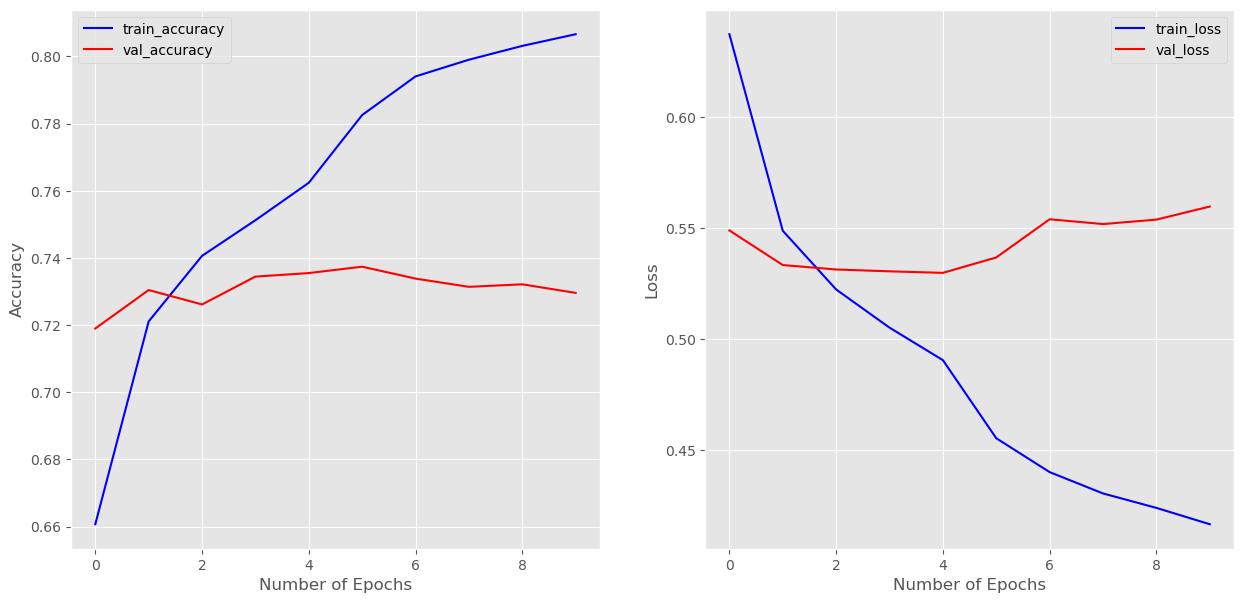

In [49]:
fig,ax=plt.subplots(1,2,figsize=(15,7))
ax[0].plot(history.history['accuracy'],c= 'b',label="train_accuracy")
ax[0].plot(history.history['val_accuracy'],c= 'r',label="val_accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(history.history['loss'],c= 'b',label="train_loss")
ax[1].plot(history.history['val_loss'],c= 'r',label="val_loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

In [50]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=1000)
y_pred_1d = [decode_sentiment(score) for score in scores]

20/20 [==============================] - 3s 104ms/step


<h3 style = 'color : orange; font-family: cambria'>V.2- Visualisation des resultats</h3>

In [52]:
### Affichage de la matrice de confusion

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.bwr):
    """
    Cette fonction trace et affiche la matrice de confusin pour ce model.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

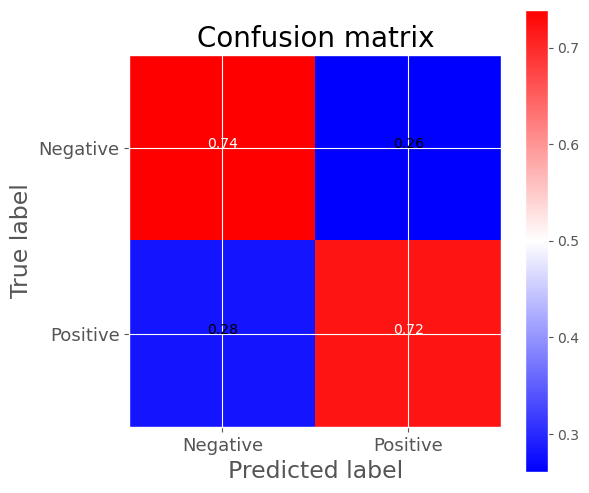

In [54]:
cnf_matrix = confusion_matrix(test_data.label.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.label.unique(), title="Confusion matrix")
plt.show()

In [56]:
#Tableau des precisions du model
print(classification_report(list(test_data.label), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.73      0.74      0.73     10024
    Positive       0.73      0.72      0.73      9976

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000



<h3 style = 'color : orange; font-family: cambria; text-align: center;'>CONCLUSION</h3>
<p style = 'border-bottom: 2px solid red'>Le Notebook est une forme experimentale d'analyse et d'entrainement d'un modèle d'analyse de données.Le modèle  entraîné a une precision de 73%<br/>
A la fin de l'entraînement du modèle final (sur le datasets final), il faudra  penser au prametrage des hyperparamètres avec keras Tuner.<br/></p>

